In [1]:
import string
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson
from sklearn.utils import check_random_state
from sklearn import cluster
from scipy.stats import poisson
from scipy.optimize import minimize

# Read the data sequence

We are given a data sequence consisting on number of earthquakes for each year between the years 1900 and 2006.

In [2]:
state_seq = []
observation_seq = []
f = open('earthquakes.txt','r')
line = f.readline()
while line:
    line=line.rstrip().split('	')
    state_seq.append(int(line[0]))
    observation_seq.append(int(line[1]))
    line = f.readline()
    
state_seq = np.array(state_seq)
observation_seq = np.array(observation_seq)

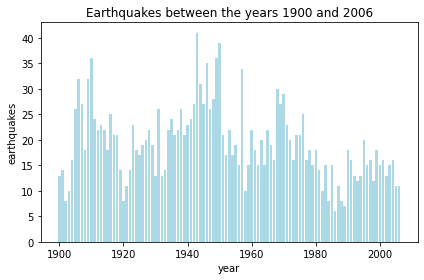

In [3]:
fig, ax = plt.subplots()

# the histogram of the data
plt.bar(state_seq, observation_seq, color='lightblue')

ax.set_xlabel('year')
ax.set_ylabel('earthquakes')
ax.set_title(r'Earthquakes between the years 1900 and 2006')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


# Direct maximization of the likelihood

The likelihood of a mixture model with m components is given, for both discrete and continuous cases by:

\begin{equation}

L(\theta_1,...,\theta_m,\delta_1,...,\delta_m|x_1,...,x_n) = \prod_{j=1}^n\sum_{i=1}^m\delta_ip_i(x_j,\theta_i)

\end{equation}
- Where $\theta_1,...,\theta_m$ are the paramenter vectors for the component distributions,
- $\delta_1,...,\delta_m$ are the mixing parameters, totalling 1,
- $x_1,...,x_n$ the $n$ observations.
Supose $m = 2$, and the two components are Poisson-distributed, which means $\lambda_1$ and $\lambda_2$. Let $\delta_1$ and $\delta_2$ be the mixing parameters (with $\delta_1+\delta_2 =1$). The mixture distribution $p$ is then given by:
\begin{equation}
p(x) = \delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x!}+\delta_2\frac{\lambda^x_2e^{-\lambda_2}}{x!}
\end{equation}
Since $\delta_2 = 1 - \delta_1$, there are only three parameters to be estimated: $\lambda_1,\lambda_2$ and $\delta_1$. The likelihood is:
\begin{equation}
L(\lambda_1,\lambda_2,\delta_1|x_1,...,x_n) = \prod_{i=1}^n\delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x_i!}+(1-\delta_1)\frac{\lambda^x_2e^{-\lambda_2}}{x_i!}
\end{equation}

The analytic maximization of $L$ with respect to $\lambda_1,\lambda_2$ and $\delta_1$ would be awkward, as $L$ is the product of $n$ factors, each of which is a sum. Therefore parameter estimation is more conveniently carried out by direct numerical maximization of the likelihood or its logarithm.
However, the parameters $\delta$ and $\lambda$ are constrained by $\sum^m_{i=1}\delta_i = 1$ and (for i=1,...,$m$)$\delta_i>0$ and $\lambda_i>0$. It is therefore necessary to reparametrize when using an unconstrained optimizer.
One possibility is to maximize the likelihood with respect to the 2m-1 unconstrained 'working parameters'.
\begin{equation}
\eta_i = log\lambda_i \; (i=1,...,m)
\end{equation}
and
\begin{equation}
\tau_i = log\left( \frac{\delta_i}{1-\sum^m_{j=2}\delta_j}\right) \; (i=2,...,m)
\end{equation}
and
\begin{equation}
\delta_1 = 1 - \sum^m_{j=2}\delta_i
\end{equation}

## Hidden Markov Models

### The likelihood

Consider a HMM in general with observation sequence $x_1,x_2,...,x_T$. The probability $L_T$ of observed that sequence is calculated under an m-state HMM which has initial distribution $\delta$ and transition probability matrix $\daleth$ for the markov chainm and state-dependent probability (density) functions $p_i$.

The likelihood is then given by:
\begin{equation}
L_T = \delta P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}
If $\delta$, the distribution of $C_1$, is the stationary distribution of the Markov chain, then in addition:
\begin{equation}
L_T = \delta\daleth P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}

#### The forward algorithm
The forward algorithm is a recursive computation of the likelihood, which is computationally much more efficient than the brute-force summation. This computational inexpensiveness is the key feature of HMMs.

We state the forward algorithm by the vector $\alpha_t$, for $t=1,2,...,T$ by:
\begin{equation}
\alpha_t = \delta P(x_1)\daleth P(x_2)...\daleth P(x_t) = \delta P(x_1)\prod_{s=2}^t\daleth P(x_s)
\end{equation}
So then the likelihood:
\begin{equation}
L_T = \alpha_T1'
\end{equation}
and:
\begin{equation}
\alpha_t = \alpha_{t-1}\daleth P(x_t) \;  for \; t\ge 2
\end{equation}

The elements of the vector $\alpha_t$ are referred as **forward probabilities**.
The number of operations is of order Tm^2. But there are several numerical problems to overcome:

- **Numerical (over/under)flow:** for discrete state-dependent distributions, the elements of $\alpha_t$, being made up of products of probabilities, become progressively smaller as $t$ increases. For the continous case, it reaches $\inf$. The solution is the same for over and underflow: scaling the vector $\alpha_t$ at eacht time $t$ so that its elemets sum up to 1.





\begin{equation}
\phi_t = \alpha_t/w_t, \; with \; w_t = \sum_i\alpha_t(i)
\end{equation}
Hence,
\begin{equation}
logL_T = \sum_{t=1}^Tlog(w_t/w_{t-1}) = \sum_{t=1}^Tlog(\phi_{t-1}\daleth P(x_t)1')
\end{equation}
- **Constraints:** we can have constrains that apply to the parameters of the state-dependent distributions, and to the parameters of the Markov chain. The relevant constrains for a Poisson HMM are:
    - the means $\lambda_i$ of the state-dependent distributions must be non-negative. This is easily solved by defining $\eta_i = \log\lambda_i$
   
    - The rows of the transition probability matrix $\daleth$ must sum up to one, with all parameters $\gamma_{ij}$ non-negative.


In [4]:
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1), 0)
    x_no_diag = x_no_diag.reshape(len(x), len(x) - 1)
    return x_no_diag
def add_zero_diag(a):    
    b = np.zeros((a.shape[0], a.shape[1]+1), dtype=a.dtype)
    i = np.arange(b.shape[0])
    j = np.arange(b.shape[1])
    b[np.not_equal.outer(i, j)] = a.flat
    return b


def pn2pw(m,lmbda,gamma,delta=None,stationary=True):
    '''natural parameters to working parametes'''        
    # contraint for lambda
    tlambda = np.log(lmbda)
    if m == 1:
        return tlambda
    # contraint for transition probability matrix
    tgamma = np.log(gamma/np.diag(gamma))
    # discard diagonal elemets from the transformed vector
    tau = remove_diag(tgamma)
    if stationary:
        tdelta = None
    else:
        tdelta = np.log(delta[-1]/delta[1])
        
    return tlambda,tau,tdelta
    
def pw2pn(m,tlambda,tau,tdelta,stationary=True):
    ''' working to natural parameters'''
    lmbda = np.exp(tlambda)
        
    # operations on tau to get off-diagonal elements of gamma
    element_exp = np.exp(tau)
    sumexp =1/(np.sum(element_exp,axis=1)+1).reshape((m,1))
    gamma = element_exp*sumexp
    # add diagonal elements to gamma
    gamma = add_zero_diag(gamma)
    gamma += np.diagflat(1-np.sum(gamma,axis=1))# fill diagonal making elements sum up to 1       
    
    if stationary:
        delta = np.linalg.solve(np.identity(m)-gamma+np.ones((m,m)),np.ones((1,m)).T)
    else:
        edelta = np.exp(tdelta)
        delta = edelta/np.sum(edelta,axis=1)
            
    return lmbda,gamma,delta
        

In [5]:
def poisson_mllk(vector,x,m,stationary):
    ''' vector has to be a 1D vector '''
    # read stored values
    # iterate as start+cellsize*index
    tlambda = vector[0:m].astype(float)
    tau = vector[m:m+m].astype(float)
    tau = tau.reshape((m,m-1))
    tdelta = vector[-1]
    if tdelta==0: tdelta = None
    else: tdelta = vector[-m]


    # if we only have 1 state
    if m==1: return (-np.sum(poisson.pmf(k=x,mu=np.exp(tlambda))))

    # get natural parameters
    lmbda,gamma,delta = pw2pn(m,tlambda,tau,tdelta,stationary=stationary)


    # for initial value
    alpha = delta.T * poisson.pmf(k=x[0],mu=lmbda)
    sum_alpha = np.sum(alpha)
    lscale = np.log(sum_alpha)
    alpha = alpha/sum_alpha  

    # for the rest of the values    
    for i in range (len(x)):
        alpha = alpha*np.matmul(gamma, poisson.pmf(k=x[i],mu=lmbda)) 
        sum_alpha = np.sum(alpha)
        lscale += np.log(sum_alpha)
        alpha = alpha/sum_alpha

        
    return -lscale

Poisson maximum likelihood estimator

In [6]:
def poisson_mle(x,m,lambda_ini,gamma_ini,delta_ini=None,stationary=True):
    ''' maximum likelihood estimation for a poisson distribution,
    given starting values for natural parameters'''
    # convert params to working parameters
    tlambda,tau,tdelta = pn2pw(m,lambda_ini,gamma_ini,delta_ini,stationary)
    # store in a vector of params to be optimized
    if tdelta == None: tdelta = 0
    partvec = np.hstack([tlambda.flatten(),tau.flatten(),tdelta])
    print('initial vector:', partvec)
    print('initial log likelihood:',poisson_mllk(partvec,x,m,stationary))
    # minimize log likelihood
    min_log = minimize(poisson_mllk,partvec,args = (x,m,stationary),method='CG', tol=1e-3)
    print('after minimization',min_log)
    # convert params from minimization to natural parameters
    tdelta = min_log.x[-1]
    if tdelta==0: tdelta = None
    else: tdelta = vector[-m]
    lmbda,gamma,delta = pw2pn(m,min_log.x[0:m],min_log.x[m:m+m],tdelta,stationary=stationary)
    

Fit a 2-state Hidden Markov Model

In [7]:
m = 2
lambda_ini = np.array([15,25])
gamma_ini = np.array([[0.9,0.1],[0.1,0.9]])
poisson_mle(observation_seq,m,lambda_ini,gamma_ini,None,True)

initial vector: [ 2.7080502   3.21887582 -2.19722458 -2.19722458  0.        ]
initial log likelihood: 384.12117497795634
after minimization      fun: 363.51733491349694
     jac: array([-2.63214111e-04,  3.05175781e-05, -6.10351562e-05,  7.62939453e-06,
        0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 414
     nit: 36
    njev: 69
  status: 0
 success: True
       x: array([ 2.74919961,  3.28187857, -0.67496134, -2.1972244 ,  0.        ])


# The EM algorithm 

## for a Mixture model of 3 Poisson distributions

In [8]:
from scipy.stats import poisson

Assuming that the earthquakes data is distributed according to a Poisson mixture model, here I will implement the EM algorithm to learn the probability parameters.

The data notation is as follows:

   - The full data $(X,Y)$ corresponding to periods with high and low amounts of earthquakes.
   - The observed data $ Y = y_i, i= 1,...,n$ corresponds to the number of earthquakes.
   - The missing data is "in what period we are for the amount of earthquakes", $X = (x_1,...,x_n) \in \{1,2,3\}^n$
   - The parameters $\theta = \{\lambda_1,\lambda_2,\lambda_3,\delta_1,\delta_2,\delta_3\}$
   
The EM algorithm converges towards a local maximum of the data log-likelihood function. It starts with an initializing value $\theta^0$, which is updated by an iterative procedure of two steps: the E step and the M step.

Considering a Poisson mixture of three components like we will do in this example, we have three disjoint events, with $\delta_k$ the probability of being in each of the three classes.
\begin{equation}
\delta_1 = P(x_i=1), \delta_2 = P(x_i=2), \delta_3 = P(x_i=3) = 1-\delta_1-\delta_2
\end{equation}
The probability of having our given data given that we are in a class k is given by:
\begin{equation}
y_i|x_i = 1∼Po(\lambda_1), y_i|x_i = 2∼Po(\lambda_2), y_i|x_i = 3∼Po(\lambda_3)
\end{equation}

In [9]:
X = state_seq
Y = observation_seq

### The E step

Since the complete log-likelihood is unknown, we use the posterior to evaluate the expectation of the complete data log-likelihood.

Computes the conditional probability that the hidden state $x_i=1$
\begin{equation}
P(X_i = 1 | Y_i = y_i) = 
\end{equation}

In [10]:
def E_step(delta,lmbda,data):
    # Handling errors
    if np.sum(delta)!=1:
        raise ValueError('Delta is not a probability distribution (the values dont sum up to 1)')
    # Conditional probability of delta given y
    delta_prob = 0
    for i in range (len(lmbda)):
        delta_prob += delta[i] * poisson.pmf(k=data,mu=lmbda[i])    
        
    # Conditional probability of each class given data
    # Probability of mixture 1 to m
    prob = []
    for i in range (len(lmbda)-1):
        prob.append(delta[i] * poisson.pmf(data,lmbda[i])/delta_prob)
      
    return prob

### The M step

Updates the probability parameters so that they maximize the expected value of the data log likelihood.

In [11]:
def M_step(prob ,delta, lmbda, data):    
    n_i = [] # number of times we expect to see each mixture, from xi = 1 to xi = m
    s_i = [] # sum of data points in the indicator components
    for i in range(len(lmbda)-1):
        n_i.append(np.sum(prob[i]))
        s_i.append(np.sum(data*prob[i]))
    n_i.append(len(data)-np.sum(n_i))
    s_i.append(np.sum(data)-np.sum(s_i))
    
    
    delta = np.asarray(n_i)/len(data)
    delta = np.append(delta,1-sum(delta))

        
    lmbda = np.divide(np.asarray(s_i),np.asarray(n_i))

    
    
    return delta, lmbda

In [12]:
def EM_algorithm(delta,lmbda,data,iterations):
    prob = 0.
    for i in range(iterations):
        prob = E_step(delta,lmbda,Y)
        delta,lmbda    = M_step(prob, delta,lmbda,Y)
        
    return delta,lmbda

In [13]:
Y = observation_seq
delta = np.array([0.5,0.4,0.1])
lmbda = np.array([10.,20.,30.])
EM_algorithm(delta,lmbda, Y, 100)

(array([0.27716677, 0.59308916, 0.12974408, 0.        ]),
 array([12.73203817, 19.78158473, 31.62645129]))

Function for a Poisson Maximum Likelihood estimator

In [14]:
from scipy.optimize import minimize, rosen, rosen_der
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
print(x0)
res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
res.x

[1.3, 0.7, 0.8, 1.9, 1.2]


array([1.00000002, 1.00000002, 1.00000007, 1.00000015, 1.00000028])